In [1]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import GridWorld_env
import gymnasium as gym
import random
import math
from itertools import count

device = "cuda" if torch.cuda.is_available() else "cpu"
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
from collections import deque, namedtuple

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayBuffer(object):
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.in_conv = nn.Conv3d(3, 32, 3, 1, 1)
        
        self.conv1 = nn.Sequential(
            nn.Conv3d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3, 1, 1),            
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3, 1, 1),         
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3, 1, 1),         
        )
        
        self.fc1 = nn.Linear((32 + 3)*input_dim * input_dim * input_dim, 512)
        self.actions = nn.Linear(512, action_dim)
        self.advantage = nn.Linear(512, 1)
    def forward(self, x):
        original_state = x
        
        x = self.in_conv(x)
        
        x = x + self.conv1(x)
        
        x = F.relu(x)
        
        x = x + self.conv2(x)
        x = F.relu(x)

        x = x + self.conv3(x)
        x = F.relu(x)
        
        x = torch.cat([x, original_state], dim=1)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = F.relu(x)
        actions = self.actions(x)
        advantage = self.advantage(x)
        x = advantage + (actions - actions.mean())
        return x

test = DQN(8, 7)
import torchinfo
torchinfo.summary(test, (1, 3, 8, 8, 8))

Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [1, 7]                    --
├─Conv3d: 1-1                            [1, 32, 8, 8, 8]          2,624
├─Sequential: 1-2                        [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-1                       [1, 32, 8, 8, 8]          27,680
│    └─ReLU: 2-2                         [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-3                       [1, 32, 8, 8, 8]          27,680
├─Sequential: 1-3                        [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-4                       [1, 32, 8, 8, 8]          27,680
│    └─ReLU: 2-5                         [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-6                       [1, 32, 8, 8, 8]          27,680
├─Sequential: 1-4                        [1, 32, 8, 8, 8]          --
│    └─Conv3d: 2-7                       [1, 32, 8, 8, 8]          27,680
│    └─ReLU: 2-8                         [1, 32, 8, 8, 8]     

In [4]:
BATCH_SIZE = 32
GAMMA = 0.85
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
STEPSIZE = 0.0000625

n_actions = 7
env = gym.make("GridWorld_env/GridWorld", dimension_size=4)
env.reset()

policy_net = DQN(4, 7)
target_net = DQN(4, 7)

policy_net.cuda()
target_net.cuda()
target_net.load_state_dict(policy_net.state_dict())

optimiser = optim.Adam(policy_net.parameters(), lr=STEPSIZE, eps=1.5e-4)
memory = ReplayBuffer(256)

steps_done = 0

In [17]:
def select_action(state, greedy = False):
    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if greedy:
        return policy_net(state).max(1).indices.view(1,1)
        
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    

In [6]:
episode_durations = []

def plot_durations(show_result = False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
        plt.pause(0.001)
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())
                

In [7]:
def optimise_model():
    if len(memory) < BATCH_SIZE:
        return 0, 0
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device = device)
    
    #double dqn
    max_a = policy_net(non_final_next_states).detach().max(1).indices
    next_state_values[non_final_mask] = target_net(non_final_next_states).detach().gather(1, max_a.unsqueeze(1)).squeeze(1)
    #next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    expected_state_action_values = GAMMA * next_state_values + reward_batch
    expected_state_action_values = expected_state_action_values.detach()
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimiser.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimiser.step()
    
    return loss.item(), reward_batch.float()
        

Complete


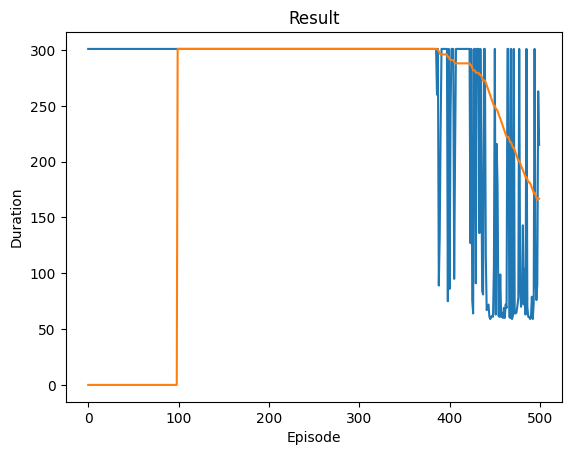

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        l, r = optimise_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    if i_episode % 30 == 0:
        print("Episode: {0} Loss {1} Mean Sample Reward {2}:" .format(i_episode, l, r.mean().item()))
        print(env.unwrapped.get_sequence())
        env.unwrapped.render()
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


In [13]:
torch.save(policy_net, "policy_converged.pt")
torch.save(target_net, "target_converged.pt")

torch

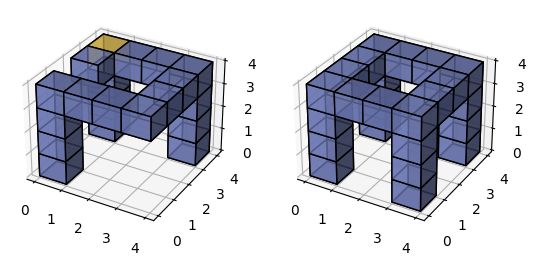

In [21]:
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
for t in count():
    action = select_action(state, greedy = True)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Store the transition in memory
    #memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state
    if terminated or truncated:
        break
    env.unwrapped.render()

    # Perform one step of the optimization (on the policy network)


In [14]:
env.reset()
state = env.get_obs()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

target_net(state)

c:\Users\Juan\anaconda3\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_obs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_obs` for environment variables or `env.get_wrapper_attr('get_obs')` that will search the reminding wrappers.
  logger.warn(


tensor([[-2.3013, -0.7766, -1.1535, -2.6998, -1.1573, -1.2182,  0.3437]],
       device='cuda:0', grad_fn=<AddBackward0>)

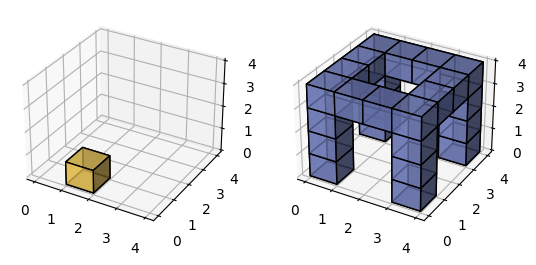

tensor([[-2.5002, -2.0741, -2.1107, -2.0921, -2.5921, -1.8428, -2.5198]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [15]:
env.step(3)
env.render()
state = env.get_obs()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

policy_net(state)

In [11]:
torch.save(policy_net, "policy.pt")

In [12]:
torch.save(target_net, "target.pt")